#### 16 Oct 2025

In [2]:
#basic_operations
import os
import math

#exploratory_data_analysis
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

#data_generation 
from scipy.interpolate import splprep, splev

#deep_learning
import torch
import torch.nn as nn
from complexPyTorch.complexLayers import ComplexLinear, ComplexReLU
from torch.utils.data import TensorDataset, DataLoader, random_split

#gpu_usage
from torch.nn.parallel import DistributedDataParallel as DDP
import torch.distributed as dist

In [3]:
# Check if CUDA is available
print("Is CUDA available?", torch.cuda.is_available())

# Total number of GPUs available
num_gpus = torch.cuda.device_count()
print(f"Number of GPUs available: {num_gpus}")

# List all GPU names
for i in range(num_gpus):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")


Is CUDA available? True
Number of GPUs available: 8
GPU 0: NVIDIA H100 80GB HBM3
GPU 1: NVIDIA H100 80GB HBM3
GPU 2: NVIDIA H100 80GB HBM3
GPU 3: NVIDIA H100 80GB HBM3
GPU 4: NVIDIA H100 80GB HBM3
GPU 5: NVIDIA H100 80GB HBM3
GPU 6: NVIDIA H100 80GB HBM3
GPU 7: NVIDIA H100 80GB HBM3


In [4]:
# Environment Parameters
epsilon = 1e-10
seed = 42


grid_min, grid_max = 0, 1
step_size = 0.1 # epsilon # distance after which angle changes.
total_time = 10
lookahead = 2
velocity = np.random.uniform(1, 5)
total_distance = velocity * total_time
num_steps = np.floor(total_distance / step_size)
rng = np.random.default_rng()

#x_initial, y_initial = np.random.uniform(grid_min, grid_max, size=2)
#head_dir_initial = math.radians(30)
#print(x_initial, y_initial)

tier_1 = np.arange(-30, 30, 1)
tier_2 = list(range(-60, -30)) + list(range(30, 60))
tier_3 = list(range(-90, -60)) + list(range(60, 90))
num_tries = 10


In [5]:
def get_future_pos(x_current, y_current, head_dir_current):
  x_future = x_current + lookahead * step_size * math.cos(head_dir_current)
  y_future = y_current + lookahead * step_size * math.sin(head_dir_current)
  return x_future, y_future

In [6]:
# Tiered search (random within tiers)
def wrap_angle(angle):
    return (angle + np.pi) % (2 * np.pi) - np.pi


def choose_head_dir(x_current, y_current, head_dir_current):
  for _ in range(num_tries):
    head_dir_next = wrap_angle(head_dir_current + math.radians(np.random.choice(tier_1)))
    x_future, y_future = get_future_pos(x_current, y_current, head_dir_next)
    if grid_min < x_future < grid_max and grid_min < y_future < grid_max:
      #print("Turning slightly")
      return x_future, y_future, head_dir_next

  for _ in range(num_tries):  
    head_dir_next = wrap_angle(head_dir_current + math.radians(np.random.choice(tier_2)))    
    x_future, y_future = get_future_pos(x_current, y_current, head_dir_next)
    if grid_min < x_future < grid_max and grid_min < y_future < grid_max:
      #print("Turning diagonally")
      return x_future, y_future, head_dir_next
  
  for _ in range(num_tries):
    head_dir_next = wrap_angle(head_dir_current + math.radians(np.random.choice(tier_3)))
    x_future, y_future = get_future_pos(x_current, y_current, head_dir_next)
    if grid_min <= x_future <= grid_max and grid_min < y_future < grid_max:
      #print("Turning almost orthagonally")
      return x_future, y_future, head_dir_next
    
  head_dir_next = wrap_angle(head_dir_current + math.radians(180))
  x_future, y_future = get_future_pos(x_current, y_current, head_dir_next)
  #print("Taking a U-turn")
  return x_future, y_future, head_dir_next

In [7]:
# Trajectory generation

def generate_trajectory(velocity):
    x_sharp = []
    y_sharp = []
    head_dir = []
    x_initial, y_initial = np.random.uniform(grid_min, grid_max, size=2)
    initial_positions = (x_initial, y_initial)
    head_dir_initial = math.radians(0)
    distance = velocity * total_time
    num_steps = np.floor(distance / step_size)

    for i in range(int(num_steps)):
        if i == 0:
            head_dir_current = head_dir_initial
            x_current, y_current = x_initial, y_initial
            x_sharp.append(x_current)
            y_sharp.append(y_current)
            head_dir.append(head_dir_current)
        
        x_future, y_future, head_dir_next = choose_head_dir(x_current, y_current, head_dir_current)
        x_next = x_current + step_size * math.cos(head_dir_next)
        y_next = y_current + step_size * math.sin(head_dir_next)
        
        head_dir_current = head_dir_next
        x_current, y_current = x_next, y_next

        x_sharp.append(x_current)
        y_sharp.append(y_current)
        head_dir.append(head_dir_current)


    x_sharp = np.array(x_sharp)
    y_sharp = np.array(y_sharp)
    head_dir = np.array(head_dir)
    initial_positions = np.array(initial_positions)
    #print(X.shape, Y.shape, HD.shape, initial_positions.shape)    
    return initial_positions, x_sharp, y_sharp    


In [8]:
# Using Spline function
def generate_smooth_trajectory(velocity):

    initial_positions, x_sharp, y_sharp = generate_trajectory(velocity)
    # s = smoothing factor, larger = smoother
    tck, u = splprep([x_sharp, y_sharp], s=0)
    u_new = np.linspace(0, 1, 1000)  # denser sampling
    x_smooth, y_smooth = splev(u_new, tck)
    return initial_positions, x_smooth, y_smooth

In [9]:
def compute_heading_vectors(x_smooth, y_smooth):
    cos_thetas, sin_thetas = [], []
    for i in range(len(x_smooth)-1):
        dx = x_smooth[i+1] - x_smooth[i]
        dy = y_smooth[i+1] - y_smooth[i]
        #heading_angle = math.atan2(dy, dx)
        norm = np.sqrt(dx**2 + dy**2) + 1e-8
        cos_theta = dx / norm
        sin_theta = dy / norm
        cos_thetas.append(cos_theta)
        sin_thetas.append(sin_theta)
    cos_thetas.append(cos_thetas[-1])  # Repeat last vector to maintain length
    sin_thetas.append(sin_thetas[-1])  # Repeat last vector to maintain length
    return cos_thetas, sin_thetas

In [10]:
def compute_abs_heading_vectors(x_smooth, y_smooth):
    cos_thetas, sin_thetas = [], []
    for i in range(len(x_smooth)):
        norm = np.sqrt(x_smooth[i]**2 + y_smooth[i]**2) + 1e-8
        cos_theta = x_smooth[i] / norm
        sin_theta = y_smooth[i] / norm
        cos_thetas.append(cos_theta)
        sin_thetas.append(sin_theta)
    return cos_thetas, sin_thetas

In [11]:
# Limb oscillations with curvature

#Parameters

dt = 0.01 # time step
time_series = np.arange(0, total_time, dt)
total_time_steps = len(time_series)

am = 0.1 # stride length
L = 0.05 # length of limb
phi = math.pi #phase difference between contralateral limbs
d = 0.05 # spacing between limb pairs

theta_m = am / (4 * L) # max angle of limb movement
limb_osc_freq = rng.uniform(1, 5) # frequency of limb oscillation
omega = 2 * math.pi * limb_osc_freq # angular frequency

def curvature(x, y):
    dx = np.gradient(x)
    dy = np.gradient(y)
    ddx = np.gradient(dx)
    ddy = np.gradient(dy)
    return (dx * ddy - dy * ddx) / ((dx**2 + dy**2)**1.5 + 1e-8)
    # To avoid division by zero

def limb_oscillations_with_curvature(t, am, L, omega, phi, d, x, y):
    theta_m = am / (4 * L)
    k = curvature(x, y)

    UFL = theta_m * (1 + k*d) * np.sin(omega*t)
    UFR = theta_m * (1 - k*d) * np.sin(omega*t + phi)
    UHR = theta_m * (1 - k*d) * np.sin(omega*t)
    UHL = theta_m * (1 + k*d) * np.sin(omega*t + phi)

    return UFL, UFR, UHR, UHL, k

In [12]:
# Generate 100 trajectories and corresponding limb oscillations

def generate_data(num_trajectories):
    x_smooth_all, y_smooth_all = [], []
    limb_data_all = []
    initial_positions_all = []
    cos_thetas_all, sin_thetas_all = [], []

    for trajectory in range(num_trajectories):
        limb_osc_freq = np.random.uniform(1, 5)
        velocity = am * limb_osc_freq
        omega = 2 * math.pi * limb_osc_freq #angular frequency
        
        initial_positions, x_smooth, y_smooth = generate_smooth_trajectory(velocity)
        cos_thetas, sin_thetas = compute_abs_heading_vectors(x_smooth, y_smooth)
        limb_data = limb_oscillations_with_curvature(time_series, am, L, omega, phi, d, x_smooth, y_smooth)
        
        initial_positions_all.append(initial_positions)
        x_smooth_all.append(x_smooth)
        y_smooth_all.append(y_smooth)
        cos_thetas_all.append(cos_thetas)
        sin_thetas_all.append(sin_thetas)
        limb_data_all.append(limb_data)


    return initial_positions_all, x_smooth_all, y_smooth_all, cos_thetas_all, sin_thetas_all, limb_data_all
    print("Generated", num_trajectories, "trajectories with corresponding limb oscillations.")

initial_positions_all, x_smooth_all, y_smooth_all, cos_thetas_all, sin_thetas_all, limb_data_all = generate_data(100)


In [14]:
initial_positions_all = np.array(initial_positions_all)
x_smooth_all = np.array(x_smooth_all)
y_smooth_all = np.array(y_smooth_all)
limb_data_all = np.array(limb_data_all)
cos_thetas_all = np.array(cos_thetas_all)
sin_thetas_all = np.array(sin_thetas_all)

print(initial_positions_all.shape, x_smooth_all.shape, y_smooth_all.shape, cos_thetas_all.shape, sin_thetas_all.shape, limb_data_all.shape)

(100, 2) (100, 1000) (100, 1000) (100, 1000) (100, 1000) (100, 5, 1000)


In [15]:
traj_data = np.stack((x_smooth_all, y_smooth_all, cos_thetas_all, sin_thetas_all), axis=-1)
traj_data = np.array(traj_data)
print(traj_data.shape) # (100, 1000, 2)

gait_data = limb_data_all.transpose(0, 2, 1)  # (num_trajectories, time_steps, 4 limbs + curvature)
print(gait_data.shape) # (100, 1000, 5)
gait_data_without_curvature = gait_data[:, :, :4]
print(gait_data_without_curvature.shape) #(100, 1000, 4)

initial_positions_all_expanded = np.repeat(initial_positions_all[:, :, np.newaxis], 1000, axis=2)
print(initial_positions_all_expanded.shape)  # (100, 2, 1000)
initial_positions_transpose = initial_positions_all_expanded.transpose(0, 2, 1)
print(initial_positions_transpose.shape)  # (100, 1000, 2)

gait_data_with_initial_pos = np.concatenate((initial_positions_transpose, gait_data_without_curvature), axis=2)
print(gait_data_with_initial_pos.shape) # (100, 1000, 6)

(100, 1000, 4)
(100, 1000, 5)
(100, 1000, 4)
(100, 2, 1000)
(100, 1000, 2)
(100, 1000, 6)


In [14]:
X = gait_data_with_initial_pos
Y = {'pos': traj_data[:, :, :2], 'hd': traj_data[:, :, 2:]}

print(X.shape, len(Y), Y['pos'].shape, Y['hd'].shape)

(100, 1000, 6) 2 (100, 1000, 2) (100, 1000, 2)


In [ ]:
# Visual cues (binary, ID-based)

def build_wall_landmarks(n_per_wall=4):
    """Generate (x,y) positions for 4 walls — used only for visibility computation."""
    pos = np.linspace(0.2, 0.8, n_per_wall)
    landmarks = []
    for y in pos: landmarks.append((0.0, y))  # left
    for y in pos: landmarks.append((1.0, y))  # right
    for x in pos: landmarks.append((x, 0.0))  # bottom
    for x in pos: landmarks.append((x, 1.0))  # top
    return np.array(landmarks)  # shape (16, 2)

def compute_visual_cues(x_smooth, y_smooth, cos_thetas, sin_thetas, landmarks, fov=np.pi):
    """Returns binary vector (time_steps, N_landmarks) for visible landmarks."""
    N = len(landmarks)
    T = len(x_smooth)
    visual = np.zeros((T, N), dtype=np.int8)
    fov_half_cos = math.cos(fov / 2)  
    for t in range(T):
        xt, yt = x_smooth[t], y_smooth[t]
        h = np.array([cos_thetas[t], sin_thetas[t]])
        for i in range(N):
            lx, ly = landmarks[i]
            r = np.array([lx - xt, ly - yt])
            dist = np.linalg.norm(r) + 1e-8
            dot = np.dot(h, r)
            cos_angle = dot / dist
            if dot > 0 and cos_angle >= fov_half_cos:
                visual[t, i] = 1
    return visual

# -------------------------
# Full data generation
# -------------------------
def generate_data(num_trajectories):
    landmarks = build_wall_landmarks()
    all_visual, all_x, all_y, all_cos, all_sin, all_limb = [], [], [], [], [], []

    for _ in range(num_trajectories):
        limb_osc_freq = np.random.uniform(1, 5)
        velocity = am * limb_osc_freq
        omega = 2 * math.pi * limb_osc_freq

        x_smooth, y_smooth = generate_smooth_trajectory(velocity)
        cos_thetas, sin_thetas = compute_heading_vectors(x_smooth, y_smooth)
        limb_data = limb_oscillations_with_curvature(time_series, am, L, omega, phi, d, x_smooth, y_smooth)
        visual = compute_visual_cues(x_smooth, y_smooth, cos_thetas, sin_thetas, landmarks, fov=np.pi)

        all_visual.append(visual)
        all_x.append(x_smooth)
        all_y.append(y_smooth)
        all_cos.append(cos_thetas)
        all_sin.append(sin_thetas)
        all_limb.append(limb_data)

    # Convert to arrays
    all_visual = np.array(all_visual)                 # (N_traj, T, 16)
    all_x, all_y = np.array(all_x), np.array(all_y)
    all_cos, all_sin = np.array(all_cos), np.array(all_sin)
    all_limb = np.array(all_limb).transpose(0, 2, 1)  # (N_traj, T, 5)

    # Build Y targets
    traj_data = np.stack((all_x, all_y, all_cos, all_sin), axis=-1)
    gait_data_without_curv = all_limb[:, :, :4]

    # Combine binary visual cues + limb oscillations
    X = np.concatenate((all_visual, gait_data_without_curv), axis=2)  # (N_traj, T, 16+4)
    Y = {'pos': traj_data[:, :, :2], 'hd': traj_data[:, :, 2:]}

    return X, Y

# -------------------------
# Run test
# -------------------------
X, Y = generate_data(100)
print("X.shape:", X.shape)                # (5, 1000, 20)
print("Y['pos'].shape:", Y['pos'].shape)  # (5, 1000, 2)
print("Y['hd'].shape:", Y['hd'].shape)    # (5, 1000, 2)


X.shape: (100, 1000, 20)
Y['pos'].shape: (100, 1000, 2)
Y['hd'].shape: (100, 1000, 2)


In [ ]:
# Plotting trajectory, position vs time and limb oscillations for five random trajectories
for i in range(5):
    traj_index = np.random.randint(0, 100)
    traj_data = Y['pos'][traj_index]
    x_traj = traj_data[:, 0]
    y_traj = traj_data[:, 1]
    limb_data_traj = 
    UFL_traj, UFR_traj, UHR_traj, UHL_traj, k_traj = limb_data_traj

    # Time vector
    t = time_series[:len(x_traj)]

    # Create a 2x2 grid
    fig, axes = plt.subplots(2, 2, figsize=(12, 8), gridspec_kw={'width_ratios': [1, 1.5]})
    fig.suptitle(f"Trajectory {traj_index+1}", fontsize=16)

    # --- Top-left: Trajectory in grid ---
    axes[0, 0].plot(x_traj, y_traj, color='blue')
    axes[0, 0].set_title('Trajectory in 2D Space')
    axes[0, 0].set_xlabel('X Position')
    axes[0, 0].set_ylabel('Y Position')
    axes[0, 0].set_xlim(0, 1)
    axes[0, 0].set_ylim(0, 1)
    axes[0, 0].grid()

    # --- Bottom-left: Position vs time ---
    axes[1, 0].plot(t, x_traj, label='X Position', color='orange')
    axes[1, 0].plot(t, y_traj, label='Y Position', color='green')
    #axes[1, 0].plot(t, head_direction_traj[:len(t)], label='Head Direction', color='purple', linestyle='--', alpha=0.7)
    axes[1, 0].set_title('Position vs Time')
    axes[1, 0].set_xlabel('Time (s)')
    axes[1, 0].set_ylabel('Position')
    axes[1, 0].legend()
    axes[1, 0].grid()

    # --- Right column (span): Limb oscillations ---
    ax_right = axes[0, 1]
    #axes[1, 1].remove()  # merge bottom cell with top
    ax_right.plot(t, UFL_traj[:len(t)], label='UFL', color='red')
    ax_right.plot(t, UFR_traj[:len(t)], label='UFR', color='blue')
    ax_right.plot(t, UHR_traj[:len(t)], label='UHR', color='green')
    ax_right.plot(t, UHL_traj[:len(t)], label='UHL', color='purple')
    ax_right.set_title('Limb Oscillations vs Time')
    ax_right.set_xlabel('Time (s)')
    ax_right.set_ylabel('Limb Angle (rad)')
    ax_right.legend()
    ax_right.grid()

    #Plotting k values
    ax_bottom_right = axes[1, 1]
    
    ax_bottom_right.plot(t, k_traj[:len(t)], label='Curvature (k)', color='black', linestyle='--', alpha=0.7)
    #ax_bottom_right.set_ylim(-30, 30)
    ax_bottom_right.legend()
    #ax_bottom_right.set_ylabel('Curvature (k)')
    #ax_k.legend(loc='upper right')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


NameError: name 'x_smooth_all' is not defined

In [19]:
#Hopf Oscillator

def real_cal(r, phi):
    return r * torch.cos(phi)

def imag_cal(r, phi):
    return r * torch.sin(phi)


def oscillator_loop(X_r, X_i, omegas, num_steps, dt=0.01, input_scaler=10.0):
    
    """
    X_r, X_i: real and imaginary parts of input signal [batch, time, units]
    omegas: angular frequencies of oscillators [1, units]
    num_steps: number of time steps
    """

    batch_size, _, units = X_r.shape
    

    # amplitude and phase initialisation
    r_t = torch.ones((batch_size, units), device=X_r.device)
    #phis = torch.zeros((batch_size, units), device=X_r.device)

    #r_t = 0.9 + 0.2 * torch.rand((batch_size, units), device=X_r.device)
    phis = (2 * math.pi) * torch.rand((batch_size, units), device=X_r.device) - math.pi

    r_list, phi_list = [], []

    for t in range(num_steps):
        # input at current time step
        input_r = input_scaler * X_r[:, t, :] * torch.cos(phis)
        input_phi = input_scaler * X_i[:, t, :] * torch.sin(phis)

        # Hopf oscillator update equations
        r_t = r_t + ((1 - r_t**2) * r_t + input_r) * dt
        phis = phis + (omegas - input_phi) * dt

        r_list.append(r_t.unsqueeze(1))   # keep time dimension
        phi_list.append(phis.unsqueeze(1))

    # Stack time axis -> shape [batch, time, units]
    r_arr = torch.cat(r_list, dim=1)
    phi_arr = torch.cat(phi_list, dim=1)
    return r_arr, phi_arr



class Hopf(nn.Module):
    def __init__(self, units, num_steps, min_f=0.1, max_f=10.1):
        super(Hopf, self).__init__()
        self.units = units
        self.num_steps = num_steps

        # Frequencies equally spaced between min_f and max_f
        omegas = torch.linspace(min_f, max_f, units) * (2 * math.pi)
        self.register_buffer('omegas', omegas.unsqueeze(0))  # [1, units]

    def forward(self, z_complex):
        """
        z_complex: complex input tensor [batch, time, units]
        """
        X_r = z_complex.real
        X_i = z_complex.imag

        r, phi = oscillator_loop(X_r, X_i, self.omegas, self.num_steps)

        z_real = real_cal(r, phi)
        z_imag = imag_cal(r, phi)
        return torch.complex(z_real, z_imag)


In [20]:

class DONN(nn.Module):
    def __init__(self, units, duration):
        super(DONN, self).__init__()

        # -----------------------------
        # Complex Dense + Hopf layers
        # -----------------------------
        self.d1 = nn.Sequential(
            ComplexLinear(X.shape[-1], units),
            ComplexReLU()
        )
        self.osc1 = Hopf(units, num_steps=duration, min_f=1, max_f=5)

        self.d2 = nn.Sequential(
            ComplexLinear(units, units),
            ComplexReLU()
        )
        self.osc2 = Hopf(units, num_steps=duration, min_f=4, max_f=8)

        self.d3 = nn.Sequential(
            ComplexLinear(units, units),
            ComplexReLU()
        )
        self.osc3 = Hopf(units, num_steps=duration, min_f=8, max_f=10)

        self.d4 = nn.Sequential(
            ComplexLinear(units, units),
            ComplexReLU()
        )

        # -----------------------------
        # Real-valued output heads
        # -----------------------------
        self.pos_out = nn.Sequential(
            nn.Linear(units * 2, 2),  # for (x, y)
            nn.Sigmoid()
        )

        self.hd_out = nn.Sequential(
            nn.Linear(units * 2, 2),  # for (cosθ, sinθ)
            nn.Tanh()
        )

    def forward(self, X):
        """
        X: [batch, time, units] real input signal
        """

        # Convert to complex
        X_c = torch.complex(X, torch.zeros_like(X))

        # Sequential complex transformations + Hopf oscillations
        d1 = self.d1(X_c)
        z1 = self.osc1(d1)

        d2 = self.d2(z1)
        z2 = self.osc2(d2)

        d3 = self.d3(z2)
        z3 = self.osc3(d3)

        d4 = self.d4(z3)

        # Concatenate real + imag for output layers
        d4_concat = torch.cat([d4.real, d4.imag], dim=-1)

        # Position output (sigmoid) → (x, y)
        pos_out = self.pos_out(d4_concat)

        # Head direction output (tanh) → (cosθ, sinθ)
        hd_out = self.hd_out(d4_concat)
        hd_norm = hd_out / (torch.norm(hd_out, dim=-1, keepdim=True) + 1e-8)

        return {"pos": pos_out, "hd": hd_norm}


In [22]:

def custom_hd_loss(hd_pred, hd_true, alpha=1.0, beta=0.5):
    """
    Custom head-direction loss combining cosine similarity + circular penalty.
    """
    # Normalize both true and predicted vectors
    hd_true = hd_true / (torch.norm(hd_true, dim=-1, keepdim=True) + 1e-8)
    hd_pred = hd_pred / (torch.norm(hd_pred, dim=-1, keepdim=True) + 1e-8)

    # Cosine similarity loss
    cos_sim = torch.sum(hd_true * hd_pred, dim=-1)
    cos_sim_loss = 1.0 - torch.mean(cos_sim)

    # Circle penalty: (cos^2 + sin^2 - 1)^2
    circle_loss = torch.mean((torch.sum(hd_pred ** 2, dim=-1) - 1.0) ** 2)

    return alpha * cos_sim_loss + beta * circle_loss


In [21]:

# Hyperparameters
units = 100
learning_rate = 0.001
batch_size = 50
epochs = 300

duration = total_time_steps  # same as in TF version

# Initialize model
model = DONN(units=units, duration=duration)

# ========================GPU Usage========================
# Template:
'''
Instantiate the model
Define primary device
Move model to primary device
Wrap things like DataParallel or DDP if needed
'''

# To use any GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

#To use a specific GPU
#device = torch.device("cuda:4")
#model.to(device)

# To use all GPUs in parallel
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model = model.to(device)
# if torch.cuda.device_count() > 1:
#     print("Using", torch.cuda.device_count(), "GPUs")
#     model = nn.DataParallel(model)

# To use a specific SET of GPUs
# device_ids = [1, 2, 3]
# device = torch.device(f'cuda:{device_ids[0]}')
# model = model.to(f'cuda:{device_ids[0]}')
# model = nn.DataParallel(model, device_ids=device_ids)

# Distributed Data Parallel (DDP)
# For large processes
# Code modularization needed for this

#Print the GPUs being used
print("Model is running on:", next(model.parameters()).device)

# ========================GPU Usage========================

# Optimizer and loss functions
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
mse_loss = nn.MSELoss()


Model is running on: cuda:0


In [23]:
# Convert NumPy arrays to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
Y_pos_tensor = torch.tensor(Y["pos"], dtype=torch.float32)
Y_hd_tensor = torch.tensor(Y["hd"], dtype=torch.float32)

# Combine into one dataset
dataset = TensorDataset(X_tensor, Y_pos_tensor, Y_hd_tensor)

# 80-20 train-validation split
val_size = int(0.2 * len(dataset))
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


In [24]:
more_epochs = 200

for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    
    batch_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
    
    for X_batch, Y_pos_batch, Y_hd_batch in batch_bar:
        X_batch, Y_pos_batch, Y_hd_batch = X_batch.to(device), Y_pos_batch.to(device), Y_hd_batch.to(device)

        optimizer.zero_grad()

        outputs = model(X_batch)
        pos_pred = outputs["pos"]
        hd_pred = outputs["hd"]

        # Compute combined loss
        loss_pos = mse_loss(pos_pred, Y_pos_batch)
        loss_hd = custom_hd_loss(hd_pred, Y_hd_batch)
        #loss_hd = mse_loss(hd_pred, Y_hd_batch)
        loss = loss_pos + loss_hd
        

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Validation
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for X_val, Y_pos_val, Y_hd_val in val_loader:
            X_val, Y_pos_val, Y_hd_val = X_val.to(device), Y_pos_val.to(device), Y_hd_val.to(device)
            outputs = model(X_val)
            pos_pred = outputs["pos"]
            hd_pred = outputs["hd"]
            val_loss += (mse_loss(pos_pred, Y_pos_val) + custom_hd_loss(Y_hd_val, hd_pred)).item()

    tqdm.write(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {total_loss/len(train_loader):.6f} | Val Loss: {val_loss/len(val_loader):.6f}")


Epoch [1/300] | Train Loss: 1.090311 | Val Loss: 1.074942


Epoch [2/300] | Train Loss: 1.082804 | Val Loss: 1.084002


Epoch [3/300] | Train Loss: 1.064999 | Val Loss: 1.078078


Epoch [4/300] | Train Loss: 1.055001 | Val Loss: 1.078897


Epoch [5/300] | Train Loss: 1.061075 | Val Loss: 1.082517


Epoch [6/300] | Train Loss: 1.050533 | Val Loss: 1.076895


Epoch [7/300] | Train Loss: 1.050471 | Val Loss: 1.078737


Epoch [8/300] | Train Loss: 1.040749 | Val Loss: 1.080605


Epoch [9/300] | Train Loss: 1.054333 | Val Loss: 1.086534


Epoch [10/300] | Train Loss: 1.045828 | Val Loss: 1.082348


Epoch [11/300] | Train Loss: 1.053213 | Val Loss: 1.085783


Epoch [12/300] | Train Loss: 1.043922 | Val Loss: 1.083808


Epoch [13/300] | Train Loss: 1.047862 | Val Loss: 1.085424


Epoch [14/300] | Train Loss: 1.044868 | Val Loss: 1.091454


Epoch [15/300] | Train Loss: 1.050447 | Val Loss: 1.085619


Epoch [16/300] | Train Loss: 1.048684 | Val Loss: 1.087757


Epoch [17/300] | Train Loss: 1.048429 | Val Loss: 1.088203


Epoch [18/300] | Train Loss: 1.045197 | Val Loss: 1.085669


Epoch [19/300] | Train Loss: 1.047251 | Val Loss: 1.086627


Epoch [20/300] | Train Loss: 1.058657 | Val Loss: 1.082345


Epoch [21/300] | Train Loss: 1.048978 | Val Loss: 1.084773


Epoch [22/300] | Train Loss: 1.048577 | Val Loss: 1.089556


Epoch [23/300] | Train Loss: 1.043542 | Val Loss: 1.085385


Epoch [24/300] | Train Loss: 1.049053 | Val Loss: 1.087700


Epoch [25/300] | Train Loss: 1.048369 | Val Loss: 1.088278


Epoch [26/300] | Train Loss: 1.052359 | Val Loss: 1.085550


Epoch [27/300] | Train Loss: 1.056291 | Val Loss: 1.085508


Epoch [28/300] | Train Loss: 1.057252 | Val Loss: 1.090634


Epoch [29/300] | Train Loss: 1.052356 | Val Loss: 1.086483


Epoch [30/300] | Train Loss: 1.056501 | Val Loss: 1.086478


Epoch [31/300] | Train Loss: 1.047697 | Val Loss: 1.087474


Epoch [32/300] | Train Loss: 1.052967 | Val Loss: 1.088228


Epoch [33/300] | Train Loss: 1.049748 | Val Loss: 1.089358


Epoch [34/300] | Train Loss: 1.048288 | Val Loss: 1.089837


Epoch [35/300] | Train Loss: 1.040814 | Val Loss: 1.084891


Epoch [36/300] | Train Loss: 1.055750 | Val Loss: 1.085015


Epoch [37/300] | Train Loss: 1.050399 | Val Loss: 1.087467


Epoch [38/300] | Train Loss: 1.056326 | Val Loss: 1.084218


Epoch [39/300] | Train Loss: 1.053556 | Val Loss: 1.086897


Epoch [40/300] | Train Loss: 1.055187 | Val Loss: 1.084261


Epoch [41/300] | Train Loss: 1.038033 | Val Loss: 1.088167


Epoch [42/300] | Train Loss: 1.046009 | Val Loss: 1.084760


Epoch [43/300] | Train Loss: 1.049465 | Val Loss: 1.085652


Epoch [44/300] | Train Loss: 1.053327 | Val Loss: 1.085345


Epoch [45/300] | Train Loss: 1.053431 | Val Loss: 1.086682


Epoch [46/300] | Train Loss: 1.059228 | Val Loss: 1.088340


Epoch [47/300] | Train Loss: 1.049929 | Val Loss: 1.084120


Epoch [48/300] | Train Loss: 1.046077 | Val Loss: 1.087382


Epoch [49/300] | Train Loss: 1.051521 | Val Loss: 1.087055


Epoch [50/300] | Train Loss: 1.045511 | Val Loss: 1.084308


Epoch [51/300] | Train Loss: 1.047844 | Val Loss: 1.086206


Epoch [52/300] | Train Loss: 1.050253 | Val Loss: 1.082861


Epoch [53/300] | Train Loss: 1.053818 | Val Loss: 1.085719


Epoch [54/300] | Train Loss: 1.038535 | Val Loss: 1.086129


Epoch [55/300] | Train Loss: 1.040363 | Val Loss: 1.083736


Epoch [56/300] | Train Loss: 1.039517 | Val Loss: 1.084723


Epoch [57/300] | Train Loss: 1.045054 | Val Loss: 1.086175


Epoch [58/300] | Train Loss: 1.046218 | Val Loss: 1.089165


Epoch [59/300] | Train Loss: 1.055072 | Val Loss: 1.088727


Epoch [60/300] | Train Loss: 1.044543 | Val Loss: 1.087952


Epoch [61/300] | Train Loss: 1.039507 | Val Loss: 1.085919


Epoch [62/300] | Train Loss: 1.050186 | Val Loss: 1.089630


Epoch [63/300] | Train Loss: 1.040292 | Val Loss: 1.086456


Epoch [64/300] | Train Loss: 1.039449 | Val Loss: 1.091313


Epoch [65/300] | Train Loss: 1.047648 | Val Loss: 1.086690


Epoch [66/300] | Train Loss: 1.048470 | Val Loss: 1.089848


Epoch [67/300] | Train Loss: 1.045410 | Val Loss: 1.086060


Epoch [68/300] | Train Loss: 1.051698 | Val Loss: 1.088402


Epoch [69/300] | Train Loss: 1.050772 | Val Loss: 1.089891


Epoch [70/300] | Train Loss: 1.046441 | Val Loss: 1.094096


Epoch [71/300] | Train Loss: 1.057557 | Val Loss: 1.090091


Epoch [72/300] | Train Loss: 1.046976 | Val Loss: 1.089632


Epoch [73/300] | Train Loss: 1.042247 | Val Loss: 1.088944


Epoch [74/300] | Train Loss: 1.048766 | Val Loss: 1.090989


Epoch [75/300] | Train Loss: 1.047195 | Val Loss: 1.087344


Epoch [76/300] | Train Loss: 1.038328 | Val Loss: 1.089912


Epoch [77/300] | Train Loss: 1.050153 | Val Loss: 1.090268


Epoch [78/300] | Train Loss: 1.047443 | Val Loss: 1.089521


Epoch [79/300] | Train Loss: 1.051904 | Val Loss: 1.085777


Epoch [80/300] | Train Loss: 1.047276 | Val Loss: 1.087960


Epoch [81/300] | Train Loss: 1.045019 | Val Loss: 1.086925


Epoch [82/300] | Train Loss: 1.037622 | Val Loss: 1.087661


Epoch [83/300] | Train Loss: 1.052754 | Val Loss: 1.085285


Epoch [84/300] | Train Loss: 1.042080 | Val Loss: 1.090937


Epoch [85/300] | Train Loss: 1.056111 | Val Loss: 1.086784


Epoch [86/300] | Train Loss: 1.058283 | Val Loss: 1.089597


Epoch [87/300] | Train Loss: 1.052749 | Val Loss: 1.086745


Epoch [88/300] | Train Loss: 1.045114 | Val Loss: 1.091984


Epoch [89/300] | Train Loss: 1.041079 | Val Loss: 1.086840


Epoch [90/300] | Train Loss: 1.045417 | Val Loss: 1.087927


Epoch [91/300] | Train Loss: 1.052782 | Val Loss: 1.087656


Epoch [92/300] | Train Loss: 1.043845 | Val Loss: 1.084079


Epoch [93/300] | Train Loss: 1.047493 | Val Loss: 1.085451


Epoch [94/300] | Train Loss: 1.051655 | Val Loss: 1.087554


Epoch [95/300] | Train Loss: 1.045787 | Val Loss: 1.085376


Epoch [96/300] | Train Loss: 1.048433 | Val Loss: 1.086569


Epoch [97/300] | Train Loss: 1.053562 | Val Loss: 1.086875


Epoch [98/300] | Train Loss: 1.051390 | Val Loss: 1.085727


Epoch [99/300] | Train Loss: 1.049007 | Val Loss: 1.083953


Epoch [100/300] | Train Loss: 1.051541 | Val Loss: 1.081928


Epoch [101/300] | Train Loss: 1.048291 | Val Loss: 1.083695


Epoch [102/300] | Train Loss: 1.046051 | Val Loss: 1.085104


Epoch [103/300] | Train Loss: 1.042954 | Val Loss: 1.082357


Epoch [104/300] | Train Loss: 1.052252 | Val Loss: 1.085548


Epoch [105/300] | Train Loss: 1.049016 | Val Loss: 1.082256


Epoch [106/300] | Train Loss: 1.039264 | Val Loss: 1.086341


Epoch [107/300] | Train Loss: 1.052328 | Val Loss: 1.085724


Epoch [108/300] | Train Loss: 1.047441 | Val Loss: 1.085129


Epoch [109/300] | Train Loss: 1.042258 | Val Loss: 1.084080


Epoch [110/300] | Train Loss: 1.044474 | Val Loss: 1.083229


Epoch [111/300] | Train Loss: 1.047829 | Val Loss: 1.080676


Epoch [112/300] | Train Loss: 1.047200 | Val Loss: 1.083354


Epoch [113/300] | Train Loss: 1.046426 | Val Loss: 1.081030


Epoch [114/300] | Train Loss: 1.050171 | Val Loss: 1.085770


Epoch [115/300] | Train Loss: 1.050832 | Val Loss: 1.082637


Epoch [116/300] | Train Loss: 1.045506 | Val Loss: 1.083528


Epoch [117/300] | Train Loss: 1.047784 | Val Loss: 1.086682


Epoch [118/300] | Train Loss: 1.051606 | Val Loss: 1.084825


Epoch [119/300] | Train Loss: 1.046090 | Val Loss: 1.084260


Epoch [120/300] | Train Loss: 1.050278 | Val Loss: 1.084387


Epoch [121/300] | Train Loss: 1.051285 | Val Loss: 1.083240


Epoch [122/300] | Train Loss: 1.054868 | Val Loss: 1.082014


Epoch [123/300] | Train Loss: 1.048226 | Val Loss: 1.083639


Epoch [124/300] | Train Loss: 1.045120 | Val Loss: 1.084415


Epoch [125/300] | Train Loss: 1.033673 | Val Loss: 1.082603


Epoch [126/300] | Train Loss: 1.037282 | Val Loss: 1.082808


Epoch [127/300] | Train Loss: 1.049329 | Val Loss: 1.083930


Epoch [128/300] | Train Loss: 1.044566 | Val Loss: 1.082570


Epoch [129/300] | Train Loss: 1.042212 | Val Loss: 1.083936


Epoch [130/300] | Train Loss: 1.036698 | Val Loss: 1.079639


Epoch [131/300] | Train Loss: 1.044271 | Val Loss: 1.086725


Epoch [132/300] | Train Loss: 1.046523 | Val Loss: 1.089314


Epoch [133/300] | Train Loss: 1.041312 | Val Loss: 1.088050


Epoch [134/300] | Train Loss: 1.046638 | Val Loss: 1.085791


Epoch [135/300] | Train Loss: 1.052298 | Val Loss: 1.082065


Epoch [136/300] | Train Loss: 1.052900 | Val Loss: 1.089110


Epoch [137/300] | Train Loss: 1.034206 | Val Loss: 1.088978


Epoch [138/300] | Train Loss: 1.042204 | Val Loss: 1.087328


Epoch [139/300] | Train Loss: 1.054132 | Val Loss: 1.091040


Epoch [140/300] | Train Loss: 1.059845 | Val Loss: 1.078979


Epoch [141/300] | Train Loss: 1.048334 | Val Loss: 1.085910


Epoch [142/300] | Train Loss: 1.039560 | Val Loss: 1.087709


Epoch [143/300] | Train Loss: 1.044768 | Val Loss: 1.079398


Epoch [144/300] | Train Loss: 1.039251 | Val Loss: 1.083018


Epoch [145/300] | Train Loss: 1.047908 | Val Loss: 1.074219


Epoch [146/300] | Train Loss: 1.048856 | Val Loss: 1.080256


Epoch [147/300] | Train Loss: 1.036978 | Val Loss: 1.079439


Epoch [148/300] | Train Loss: 1.052296 | Val Loss: 1.072882


Epoch [149/300] | Train Loss: 1.037149 | Val Loss: 1.077158


Epoch [150/300] | Train Loss: 1.048048 | Val Loss: 1.079278


Epoch [151/300] | Train Loss: 1.051344 | Val Loss: 1.080583


Epoch [152/300] | Train Loss: 1.048990 | Val Loss: 1.078471


Epoch [153/300] | Train Loss: 1.050642 | Val Loss: 1.080770


Epoch [154/300] | Train Loss: 1.041135 | Val Loss: 1.063436


Epoch [155/300] | Train Loss: 1.044418 | Val Loss: 1.090918


Epoch [156/300] | Train Loss: 1.040831 | Val Loss: 1.087342


Epoch [157/300] | Train Loss: 1.042203 | Val Loss: 1.092215


Epoch [158/300] | Train Loss: 1.047685 | Val Loss: 1.075011


Epoch [159/300] | Train Loss: 1.034731 | Val Loss: 1.070190


Epoch [160/300] | Train Loss: 1.037474 | Val Loss: 1.069984


Epoch [161/300] | Train Loss: 1.053185 | Val Loss: 1.060361


Epoch [162/300] | Train Loss: 1.039878 | Val Loss: 1.061871


Epoch [163/300] | Train Loss: 1.030978 | Val Loss: 1.079178


Epoch [164/300] | Train Loss: 1.039876 | Val Loss: 1.091799


Epoch [165/300] | Train Loss: 1.029796 | Val Loss: 1.058525


Epoch [166/300] | Train Loss: 1.047721 | Val Loss: 1.047829


Epoch [167/300] | Train Loss: 1.046451 | Val Loss: 1.050265


Epoch [168/300] | Train Loss: 1.029841 | Val Loss: 1.049992


Epoch [169/300] | Train Loss: 1.028332 | Val Loss: 1.087010


Epoch [170/300] | Train Loss: 1.037966 | Val Loss: 1.089461


Epoch [171/300] | Train Loss: 1.025357 | Val Loss: 1.077839


Epoch [172/300] | Train Loss: 1.042320 | Val Loss: 1.068707


Epoch [173/300] | Train Loss: 1.023989 | Val Loss: 1.037113


Epoch [174/300] | Train Loss: 1.019413 | Val Loss: 1.027632


Epoch [175/300] | Train Loss: 1.037694 | Val Loss: 1.064526


Epoch [176/300] | Train Loss: 1.029132 | Val Loss: 1.060601


Epoch [177/300] | Train Loss: 1.024450 | Val Loss: 1.037243


Epoch [178/300] | Train Loss: 1.017247 | Val Loss: 1.011575


Epoch [179/300] | Train Loss: 1.019749 | Val Loss: 1.083868


Epoch [180/300] | Train Loss: 1.016688 | Val Loss: 1.026379


Epoch [181/300] | Train Loss: 0.997707 | Val Loss: 1.032374


Epoch [182/300] | Train Loss: 1.017724 | Val Loss: 0.997942


Epoch [183/300] | Train Loss: 0.995116 | Val Loss: 1.053090


Epoch [184/300] | Train Loss: 0.995338 | Val Loss: 1.036673


Epoch [185/300] | Train Loss: 1.008974 | Val Loss: 0.986997


Epoch [186/300] | Train Loss: 0.985546 | Val Loss: 1.060161


Epoch [187/300] | Train Loss: 0.999976 | Val Loss: 1.037750


Epoch [188/300] | Train Loss: 1.021493 | Val Loss: 0.971253


Epoch [189/300] | Train Loss: 0.980456 | Val Loss: 1.009846


Epoch [190/300] | Train Loss: 0.982770 | Val Loss: 1.038775


Epoch [191/300] | Train Loss: 0.981982 | Val Loss: 0.983844


Epoch [192/300] | Train Loss: 0.984297 | Val Loss: 0.987377


Epoch [193/300] | Train Loss: 0.996668 | Val Loss: 1.009906


Epoch [194/300] | Train Loss: 1.025813 | Val Loss: 0.969254


Epoch [195/300] | Train Loss: 0.960962 | Val Loss: 0.992712


Epoch [196/300] | Train Loss: 0.949758 | Val Loss: 1.006083


Epoch [197/300] | Train Loss: 0.949987 | Val Loss: 1.030812


Epoch [198/300] | Train Loss: 0.964030 | Val Loss: 0.966865


Epoch [199/300] | Train Loss: 0.996393 | Val Loss: 0.986201


Epoch [200/300] | Train Loss: 0.977629 | Val Loss: 0.994533


Epoch [201/300] | Train Loss: 1.008363 | Val Loss: 0.974581


Epoch [202/300] | Train Loss: 0.974154 | Val Loss: 1.004789


Epoch [203/300] | Train Loss: 0.971790 | Val Loss: 1.001099


Epoch [204/300] | Train Loss: 0.959287 | Val Loss: 1.001622


Epoch [205/300] | Train Loss: 0.956798 | Val Loss: 0.968244


Epoch [206/300] | Train Loss: 0.966425 | Val Loss: 0.993593


Epoch [207/300] | Train Loss: 0.952128 | Val Loss: 1.014247


Epoch [208/300] | Train Loss: 0.938779 | Val Loss: 0.957499


Epoch [209/300] | Train Loss: 0.939916 | Val Loss: 1.013924


Epoch [210/300] | Train Loss: 0.914473 | Val Loss: 1.020915


Epoch [211/300] | Train Loss: 0.954102 | Val Loss: 1.014947


Epoch [212/300] | Train Loss: 0.955731 | Val Loss: 1.015570


Epoch [213/300] | Train Loss: 0.942290 | Val Loss: 0.962989


Epoch [214/300] | Train Loss: 0.943872 | Val Loss: 1.063322


Epoch [215/300] | Train Loss: 0.929823 | Val Loss: 0.998596


Epoch [216/300] | Train Loss: 0.950525 | Val Loss: 1.008359


Epoch [217/300] | Train Loss: 0.942007 | Val Loss: 1.012179


Epoch [218/300] | Train Loss: 0.933588 | Val Loss: 0.975919


Epoch [219/300] | Train Loss: 0.942964 | Val Loss: 0.969546


Epoch [220/300] | Train Loss: 0.945280 | Val Loss: 1.005440


Epoch [221/300] | Train Loss: 0.938538 | Val Loss: 0.982652


Epoch [222/300] | Train Loss: 0.931156 | Val Loss: 0.997436


Epoch [223/300] | Train Loss: 0.902032 | Val Loss: 0.976540


Epoch [224/300] | Train Loss: 0.922954 | Val Loss: 1.049071


Epoch [225/300] | Train Loss: 0.941028 | Val Loss: 0.978793


Epoch [226/300] | Train Loss: 0.907990 | Val Loss: 1.082224


Epoch [227/300] | Train Loss: 0.918711 | Val Loss: 0.997939


Epoch [228/300] | Train Loss: 0.920327 | Val Loss: 0.951845


Epoch [229/300] | Train Loss: 0.932033 | Val Loss: 0.995186


Epoch [230/300] | Train Loss: 0.939465 | Val Loss: 1.029231


Epoch [231/300] | Train Loss: 0.919677 | Val Loss: 0.992150


Epoch [232/300] | Train Loss: 0.939572 | Val Loss: 0.992673


Epoch [233/300] | Train Loss: 0.900670 | Val Loss: 0.930719


Epoch [234/300] | Train Loss: 0.928250 | Val Loss: 0.997145


Epoch [235/300] | Train Loss: 0.960281 | Val Loss: 0.967591


Epoch [236/300] | Train Loss: 0.900370 | Val Loss: 0.961528


Epoch [237/300] | Train Loss: 0.922478 | Val Loss: 0.987038


Epoch [238/300] | Train Loss: 0.938044 | Val Loss: 0.969922


Epoch [239/300] | Train Loss: 0.911173 | Val Loss: 0.973991


Epoch [240/300] | Train Loss: 0.898186 | Val Loss: 0.953683


Epoch [241/300] | Train Loss: 0.941734 | Val Loss: 1.006677


Epoch [242/300] | Train Loss: 0.908690 | Val Loss: 1.007639


Epoch [243/300] | Train Loss: 0.924955 | Val Loss: 0.958327


Epoch [244/300] | Train Loss: 0.924642 | Val Loss: 0.945743


Epoch [245/300] | Train Loss: 0.910003 | Val Loss: 0.941948


Epoch [246/300] | Train Loss: 0.908267 | Val Loss: 0.851451


Epoch [247/300] | Train Loss: 0.935898 | Val Loss: 0.937352


Epoch [248/300] | Train Loss: 0.910279 | Val Loss: 0.950152


Epoch [249/300] | Train Loss: 0.907741 | Val Loss: 0.970791


Epoch [250/300] | Train Loss: 0.927150 | Val Loss: 0.992500


Epoch [251/300] | Train Loss: 0.904985 | Val Loss: 0.944584


Epoch [252/300] | Train Loss: 0.908518 | Val Loss: 0.987593


Epoch [253/300] | Train Loss: 0.918090 | Val Loss: 1.025153


Epoch [254/300] | Train Loss: 0.927199 | Val Loss: 0.990273


Epoch [255/300] | Train Loss: 0.910704 | Val Loss: 1.029317


Epoch [256/300] | Train Loss: 0.905401 | Val Loss: 1.006967


Epoch [257/300] | Train Loss: 0.914473 | Val Loss: 0.963685


Epoch [258/300] | Train Loss: 0.920687 | Val Loss: 0.966086


Epoch [259/300] | Train Loss: 0.911100 | Val Loss: 0.992423


Epoch [260/300] | Train Loss: 0.916850 | Val Loss: 0.947361


Epoch [261/300] | Train Loss: 0.905421 | Val Loss: 0.969362


Epoch [262/300] | Train Loss: 0.928111 | Val Loss: 0.987610


Epoch [263/300] | Train Loss: 0.907798 | Val Loss: 0.988681


Epoch [264/300] | Train Loss: 0.934060 | Val Loss: 1.019030


Epoch [265/300] | Train Loss: 0.921744 | Val Loss: 0.949032


Epoch [266/300] | Train Loss: 0.930787 | Val Loss: 1.004079


Epoch [267/300] | Train Loss: 0.920209 | Val Loss: 0.972289


Epoch [268/300] | Train Loss: 0.913379 | Val Loss: 0.958326


Epoch [269/300] | Train Loss: 0.913780 | Val Loss: 0.974015


Epoch [270/300] | Train Loss: 0.890389 | Val Loss: 0.963587


Epoch [271/300] | Train Loss: 0.919057 | Val Loss: 0.978462


Epoch [272/300] | Train Loss: 0.893446 | Val Loss: 0.978131


Epoch [273/300] | Train Loss: 0.921292 | Val Loss: 0.973713


Epoch [274/300] | Train Loss: 0.923470 | Val Loss: 0.960019


Epoch [275/300] | Train Loss: 0.924060 | Val Loss: 0.946803


Epoch [276/300] | Train Loss: 0.926330 | Val Loss: 0.950224


Epoch [277/300] | Train Loss: 0.918815 | Val Loss: 0.990070


Epoch [278/300] | Train Loss: 0.906050 | Val Loss: 0.974787


Epoch [279/300] | Train Loss: 0.906349 | Val Loss: 0.980485


Epoch [280/300] | Train Loss: 0.903521 | Val Loss: 0.956662


Epoch [281/300] | Train Loss: 0.916658 | Val Loss: 0.979567


Epoch [282/300] | Train Loss: 0.928151 | Val Loss: 0.978745


Epoch [283/300] | Train Loss: 0.949503 | Val Loss: 0.975282


Epoch [284/300] | Train Loss: 0.911688 | Val Loss: 0.979595


Epoch [285/300] | Train Loss: 0.935248 | Val Loss: 0.981059


Epoch [286/300] | Train Loss: 0.899258 | Val Loss: 0.970871


Epoch [287/300] | Train Loss: 0.901885 | Val Loss: 0.971008


Epoch [288/300] | Train Loss: 0.900712 | Val Loss: 0.967280


Epoch [289/300] | Train Loss: 0.961710 | Val Loss: 0.948540


Epoch [290/300] | Train Loss: 0.908471 | Val Loss: 0.975664


Epoch [291/300] | Train Loss: 0.900113 | Val Loss: 0.977253


Epoch [292/300] | Train Loss: 0.907716 | Val Loss: 0.993289


Epoch [293/300] | Train Loss: 0.921619 | Val Loss: 0.967012


Epoch [294/300] | Train Loss: 0.923404 | Val Loss: 0.983832


Epoch [295/300] | Train Loss: 0.916413 | Val Loss: 0.964315


Epoch [296/300] | Train Loss: 0.922118 | Val Loss: 0.974821


Epoch [297/300] | Train Loss: 0.922169 | Val Loss: 0.982457


Epoch [298/300] | Train Loss: 0.920161 | Val Loss: 0.966754


Epoch [299/300] | Train Loss: 0.897557 | Val Loss: 0.973830


Epoch [300/300] | Train Loss: 0.905165 | Val Loss: 0.983790


In [ ]:
torch.save(model.state_dict(), "weights/2d_weights_v2_abs_hd_rand_initial_phi.pth")


In [44]:
model = DONN(units=100, duration=total_time_steps)  # same architecture
model.load_state_dict(torch.load("weights/2d_weights_v2_abs_hd.pth"))
model.to(device)  # send to GPU if needed
model.eval()      # set to evaluation mode if needed

DONN(
  (d1): Sequential(
    (0): ComplexLinear(
      (fc_r): Linear(in_features=6, out_features=100, bias=True)
      (fc_i): Linear(in_features=6, out_features=100, bias=True)
    )
    (1): ComplexReLU()
  )
  (osc1): Hopf()
  (d2): Sequential(
    (0): ComplexLinear(
      (fc_r): Linear(in_features=100, out_features=100, bias=True)
      (fc_i): Linear(in_features=100, out_features=100, bias=True)
    )
    (1): ComplexReLU()
  )
  (osc2): Hopf()
  (d3): Sequential(
    (0): ComplexLinear(
      (fc_r): Linear(in_features=100, out_features=100, bias=True)
      (fc_i): Linear(in_features=100, out_features=100, bias=True)
    )
    (1): ComplexReLU()
  )
  (osc3): Hopf()
  (d4): Sequential(
    (0): ComplexLinear(
      (fc_r): Linear(in_features=100, out_features=100, bias=True)
      (fc_i): Linear(in_features=100, out_features=100, bias=True)
    )
    (1): ComplexReLU()
  )
  (pos_out): Sequential(
    (0): Linear(in_features=200, out_features=2, bias=True)
    (1): Sigmoid()

In [45]:
with torch.no_grad():
    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
    predictions = model(X_tensor)
    pos_pred = predictions['pos'].cpu().numpy()
    hd_pred = predictions['hd'].cpu().numpy()

In [46]:
print(pos_pred.shape, hd_pred.shape)

(100, 1000, 2) (100, 1000, 2)


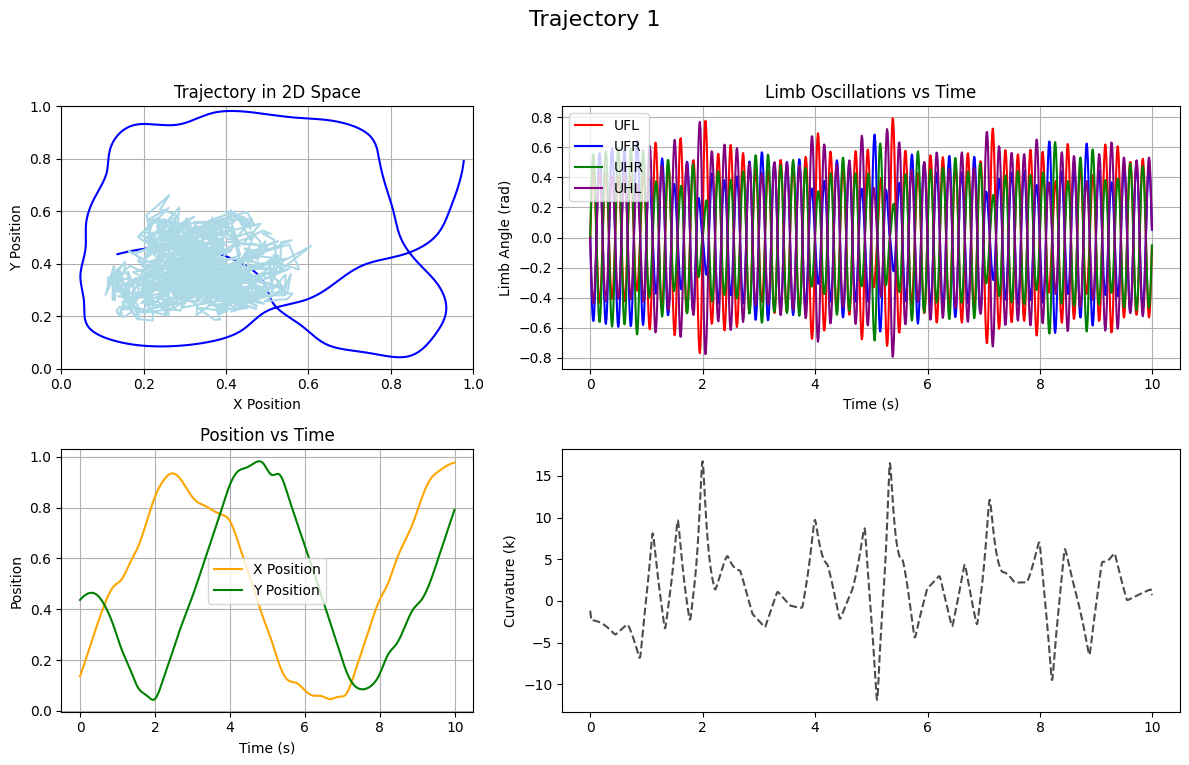

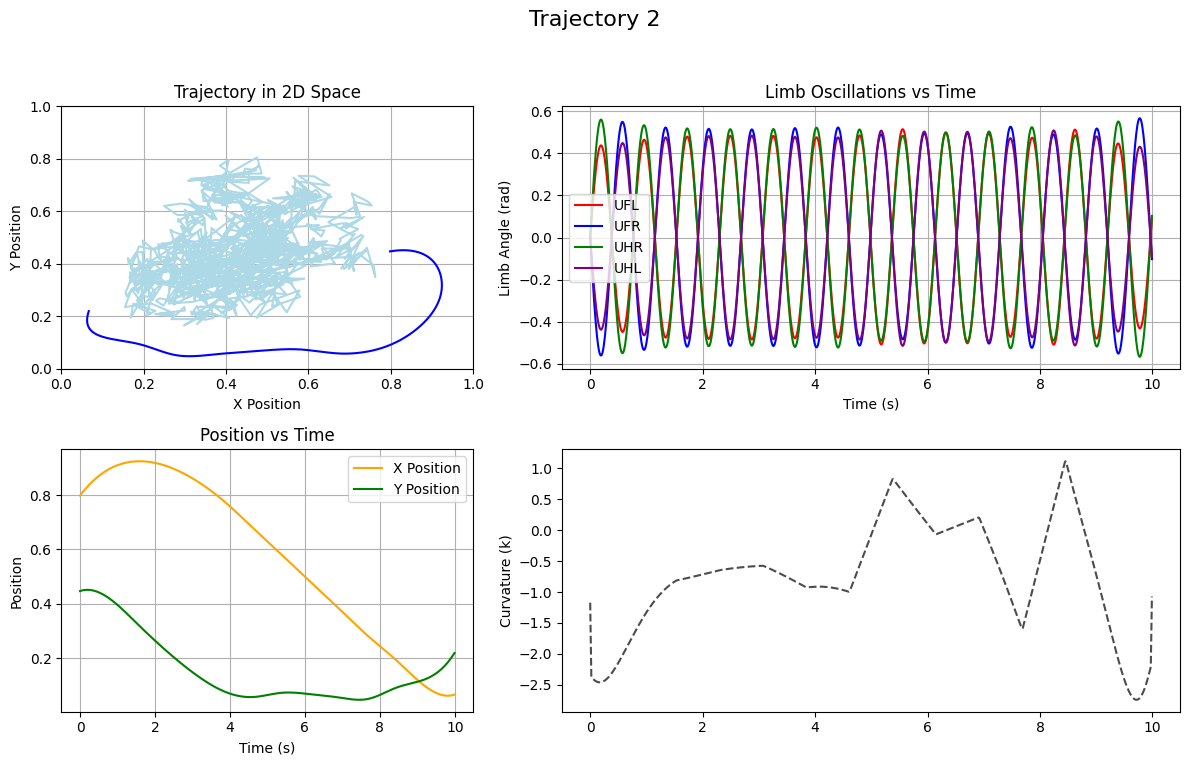

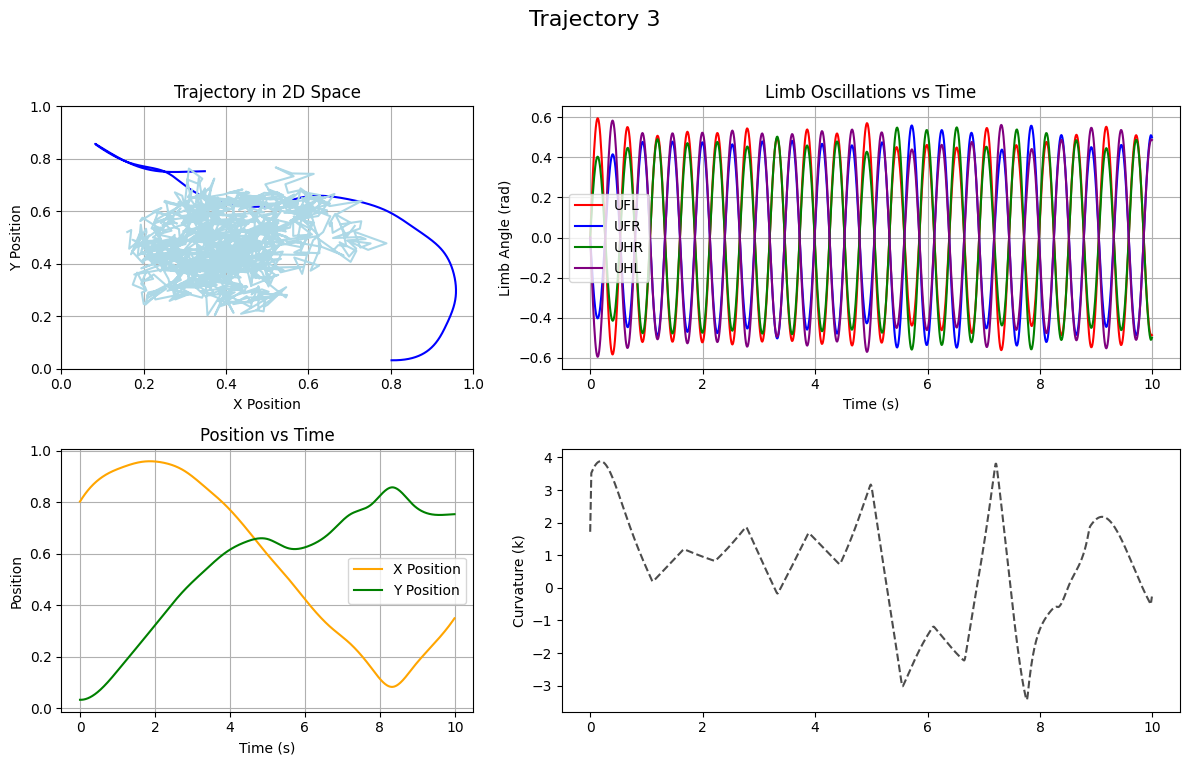

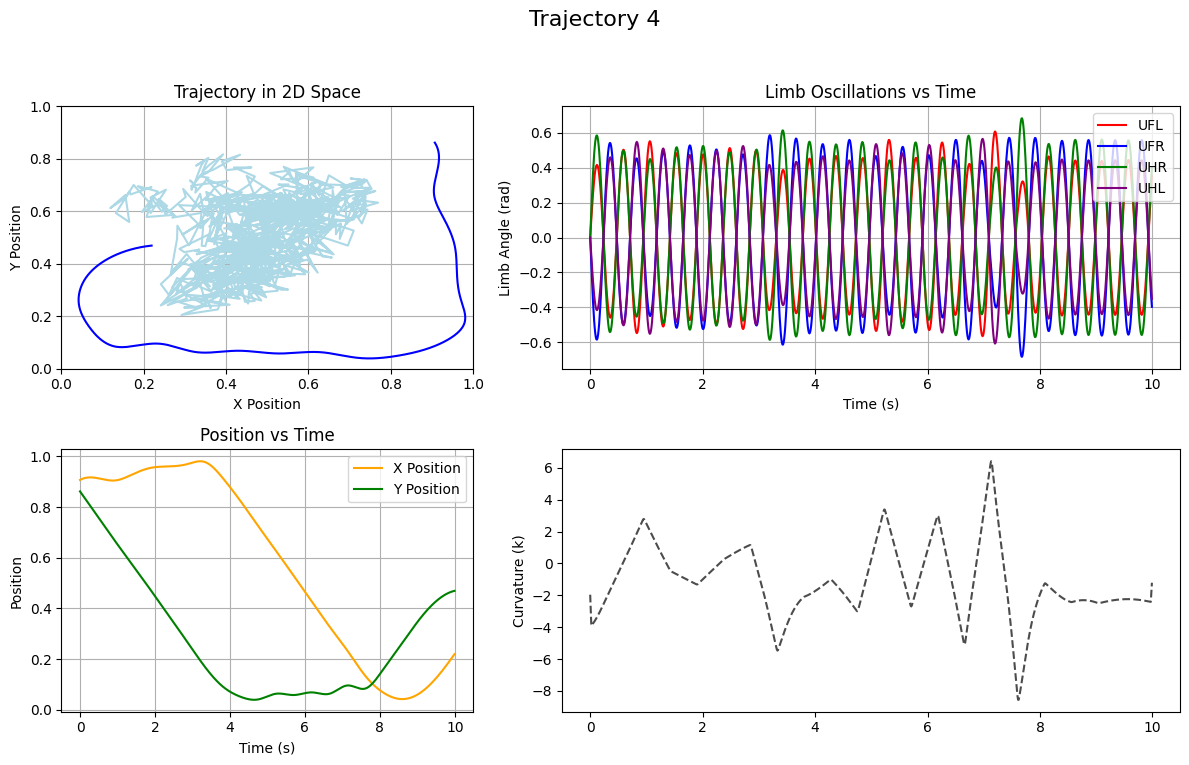

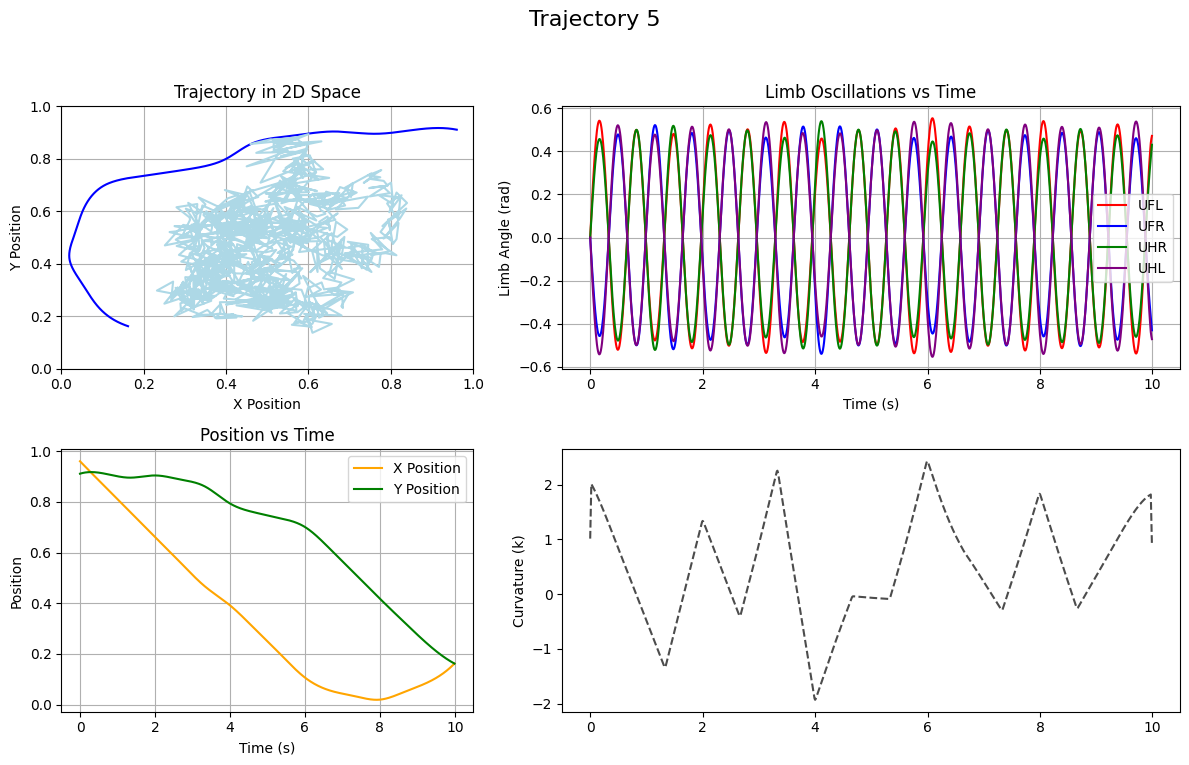

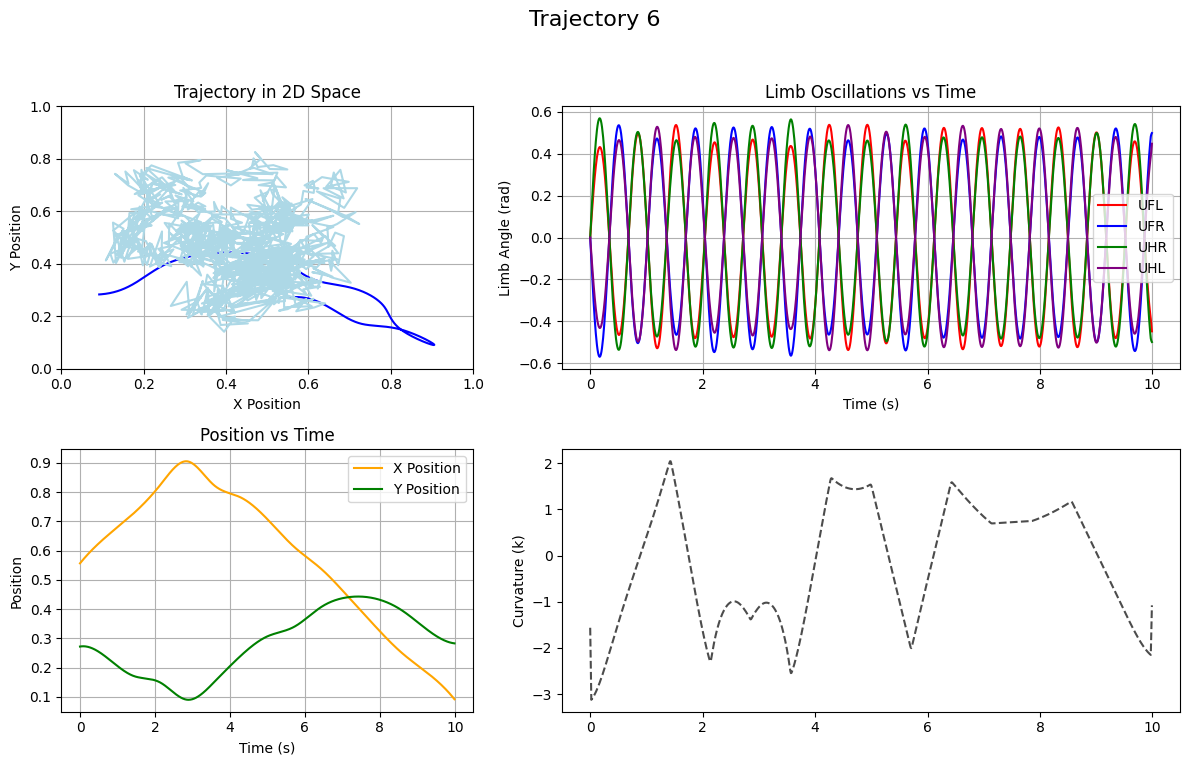

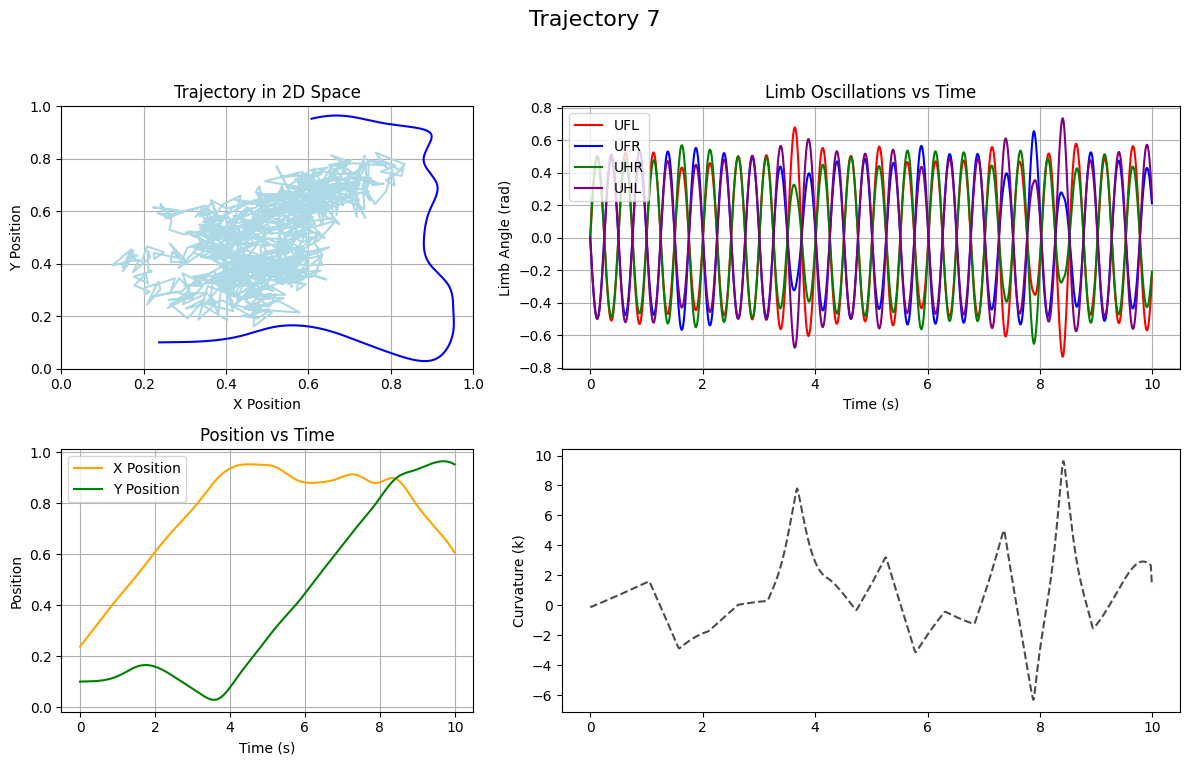

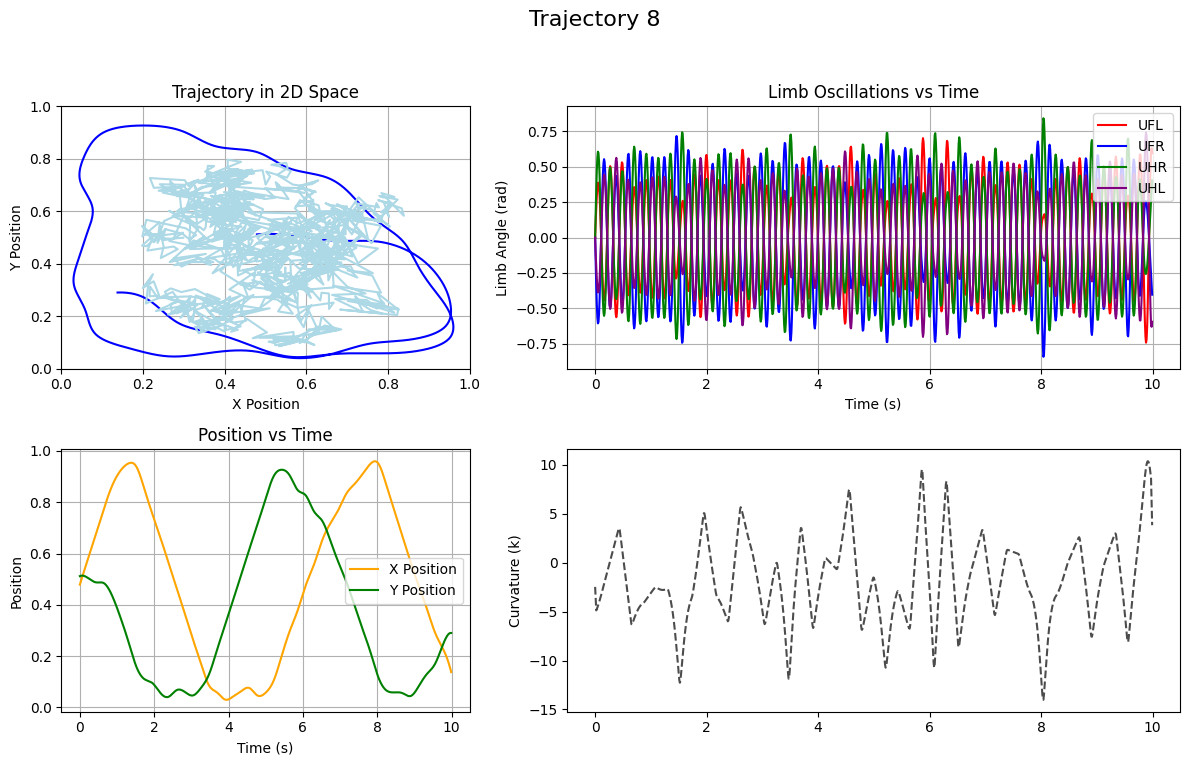

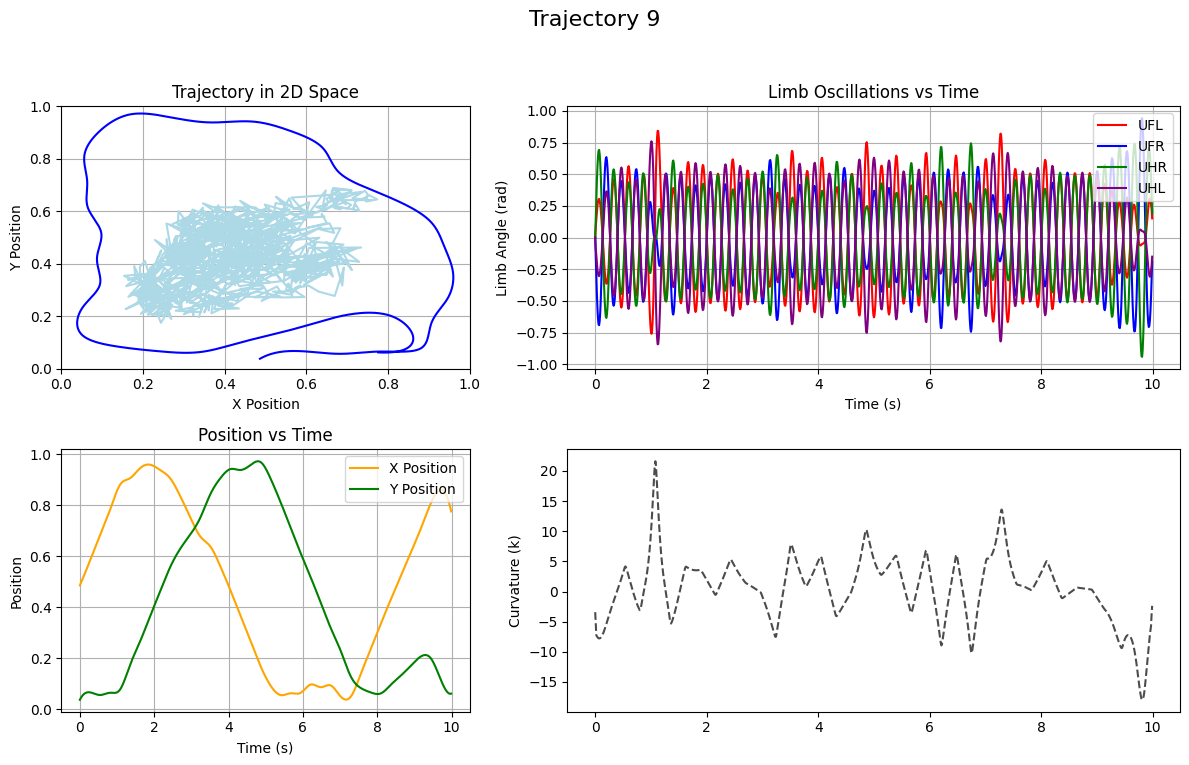

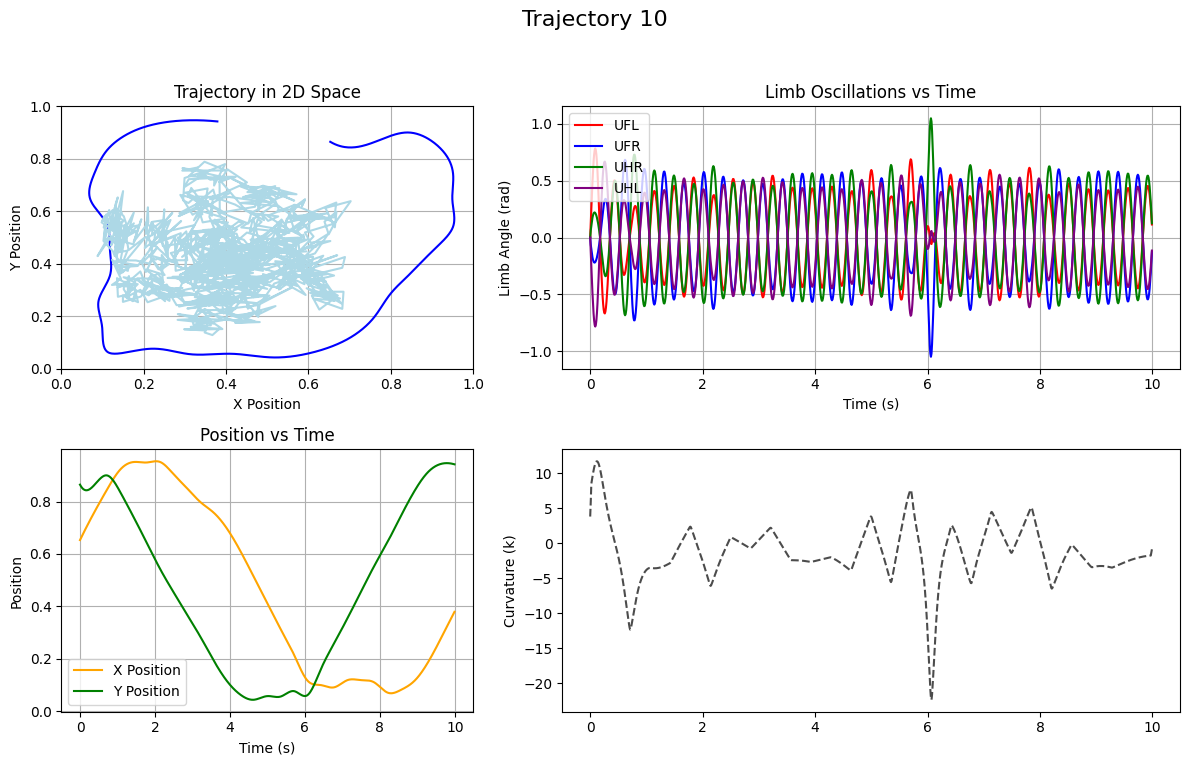

In [47]:
# Plotting trajectory, position vs time and limb oscillations for five random trajectories
for i in range(0, 10):

    #traj_index = np.random.randint(0, 100)
    traj_index = i
    X_traj = x_smooth_all[traj_index]
    Y_traj = y_smooth_all[traj_index]
    limb_data_traj = limb_data_all[traj_index]
    UFL, UFR, UHR, UHL, k = limb_data_traj

    # Time vector
    t = time_series[:len(X_traj)]

    # Create a 2x2 grid
    fig, axes = plt.subplots(2, 2, figsize=(12, 8), gridspec_kw={'width_ratios': [1, 1.5]})
    fig.suptitle(f"Trajectory {traj_index+1}", fontsize=16)

    # --- Top-left: Trajectory in grid ---
    axes[0, 0].plot(X_traj, Y_traj, color='blue')
    axes[0, 0].plot(pos_pred[traj_index, :, 0], pos_pred[traj_index, :, 1], color='lightblue')
    axes[0, 0].set_title('Trajectory in 2D Space')
    axes[0, 0].set_xlabel('X Position')
    axes[0, 0].set_ylabel('Y Position')
    axes[0, 0].set_xlim(0, 1)
    axes[0, 0].set_ylim(0, 1)
    axes[0, 0].grid()

    # --- Bottom-left: Position vs time ---
    axes[1, 0].plot(t, X_traj, label='X Position', color='orange')
    axes[1, 0].plot(t, Y_traj, label='Y Position', color='green')
    axes[1, 0].set_title('Position vs Time')
    axes[1, 0].set_xlabel('Time (s)')
    axes[1, 0].set_ylabel('Position')
    axes[1, 0].legend()
    axes[1, 0].grid()

    # --- Right column (span): Limb oscillations ---
    ax_right = axes[0, 1]
    #axes[1, 1].remove()  # merge bottom cell with top
    ax_right.plot(t, UFL[:len(t)], label='UFL', color='red')
    ax_right.plot(t, UFR[:len(t)], label='UFR', color='blue')
    ax_right.plot(t, UHR[:len(t)], label='UHR', color='green')
    ax_right.plot(t, UHL[:len(t)], label='UHL', color='purple')
    ax_right.set_title('Limb Oscillations vs Time')
    ax_right.set_xlabel('Time (s)')
    ax_right.set_ylabel('Limb Angle (rad)')
    ax_right.legend()
    ax_right.grid()

    #Plotting k values
    ax_bottom_right = axes[1, 1]
    
    ax_bottom_right.plot(t, k[:len(t)], label='Curvature (k)', color='black', linestyle='--', alpha=0.7)
    ax_bottom_right.set_ylabel('Curvature (k)')
    #ax_k.legend(loc='upper right')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
